In [55]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm, binom, sem
from scipy.stats import binom_test, t, ttest_ind
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

## Первичный анализ групп

In [2]:
users_verifications = pd.read_csv('data/users_and_verifications.csv')

In [3]:
users_verifications.head()

,user_id,experiment_group,UserType,RegistrationTime,item_id,discount_day
0,273049750501,no_discount,Private,2016-12-07 17:20:07.382,4.133708e+11,2021-10-01
1,5131250049,30_discount,Private,2013-11-20 05:08:14.065,5.420683e+11,2021-10-01
2,374964778,30_discount,Private,2012-10-07 13:43:50.728,5.903628e+11,2021-10-11
3,464891750010,30_discount,Private,2019-03-31 11:28:13.981,6.926855e+11,2021-10-09
4,167540750020,no_discount,Private,2015-11-13 16:58:14.951,7.204115e+11,2021-10-12


In [4]:
users_verifications['RegistrationTime'] = pd.to_datetime(users_verifications['RegistrationTime'])

In [5]:
users_verifications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770035 entries, 0 to 770034
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           770035 non-null  int64         
 1   experiment_group  770035 non-null  object        
 2   UserType          770035 non-null  object        
 3   RegistrationTime  770035 non-null  datetime64[ns]
 4   item_id           29963 non-null   float64       
 5   discount_day      29963 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 35.2+ MB


In [6]:
#посмотрим есть ли зарегистрированные после начала эксперимента

users_verifications[users_verifications['RegistrationTime'] >= '2021-09-15']

,user_id,experiment_group,UserType,RegistrationTime,item_id,discount_day


In [7]:
users_verifications_ndis = users_verifications[users_verifications['experiment_group'] == 'no_discount']
users_verifications_30dis = users_verifications[users_verifications['experiment_group'] == '30_discount']
users_verifications_60dis = users_verifications[users_verifications['experiment_group'] == '60_discount']

In [8]:
# В переменных ниже будем хранить пользователей по группам
users_ndis = users_verifications_ndis['user_id'].unique()
users_30dis = users_verifications_30dis['user_id'].unique()
users_60dis = users_verifications_60dis['user_id'].unique()

In [9]:
print(f"Количество пользователей в группе no_discounts: {len(users_ndis)} пользователей")
print(f"Количество пользователей в группе 30_discounts: {len(users_30dis)} пользователей")
print(f"Количество пользователей в группе 60_discounts: {len(users_60dis)} пользователей")

Количество пользователей в группе no_discounts: 255626 пользователей
Количество пользователей в группе 30_discounts: 253663 пользователей
Количество пользователей в группе 60_discounts: 253441 пользователей


Посмотрим на доли типов пользователей в группах

In [10]:
users_type_ndis = users_verifications_ndis[['user_id', 'UserType']].drop_duplicates()['UserType'].value_counts()
users_type_30dis = users_verifications_30dis[['user_id', 'UserType']].drop_duplicates()['UserType'].value_counts()
users_type_60dis = users_verifications_60dis[['user_id', 'UserType']].drop_duplicates()['UserType'].value_counts()

In [11]:
users_type_ndis /= len(users_verifications_ndis['user_id'])
users_type_30dis /= len(users_verifications_30dis['user_id'])
users_type_60dis /= len(users_verifications_60dis['user_id'])

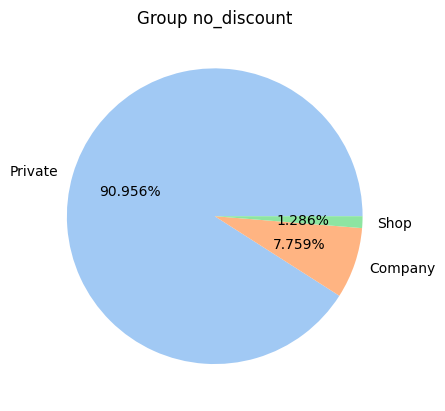

In [12]:
labels = ['Private', 'Company', 'Shop']
colors = sns.color_palette('pastel')[ 0:3 ]
plt.title('Group no_discount')
plt.pie(users_type_ndis, labels = labels, colors = colors, autopct='%.3f%%')
plt.show()

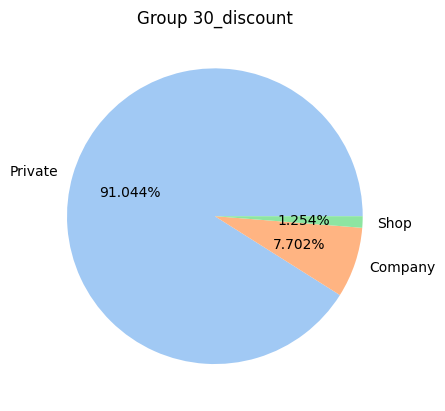

In [13]:
plt.title('Group 30_discount')
plt.pie(users_type_30dis, labels = labels, colors = colors, autopct='%.3f%%')
plt.show()

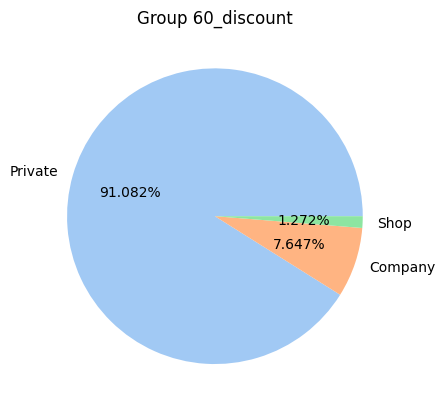

In [14]:
plt.title('Group 60_discount')
plt.pie(users_type_60dis, labels = labels, colors = colors, autopct='%.3f%%')
plt.show()

#### Сравним ARPU по группам

`users_and_pays_perday.csv` - датасет с данными о суммарной оплате каждого пользователя за определенный день

In [15]:
users_pays_pday = pd.read_csv('data/users_and_pays_perday.csv')
users_pays_pday.head()

,user_id,event_date,net_pday
0,101,2021-06-02,69.230769
1,101,2021-06-19,32.384615
2,101,2021-07-02,69.230769
3,101,2021-07-03,46.692308
4,101,2021-07-21,32.384615


In [16]:
users_pays_pday['event_date'] = pd.to_datetime(users_pays_pday['event_date'])

In [17]:
users_pays_pday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395069 entries, 0 to 2395068
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int64         
 1   event_date  datetime64[ns]
 2   net_pday    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 54.8 MB


Посмотрим, как тратили пользователи до начала эксперимента

In [18]:
users_pays_pday_before = users_pays_pday[users_pays_pday['event_date'] < '2021-09-15']

In [19]:
DAYS_BEFORE = (users_pays_pday_before['event_date'].max() - users_pays_pday_before['event_date'].min()) / np.timedelta64 ( 1 , 'D') + 1
print(f"{DAYS_BEFORE} дней наблюдений до эксперимента")

106.0 дней наблюдений до эксперимента


Поделим платежи по группам

In [20]:
users_pays_pday_before_ndis = users_pays_pday_before[users_pays_pday_before['user_id'].isin(users_ndis)]
users_pays_pday_before_30dis = users_pays_pday_before[users_pays_pday_before['user_id'].isin(users_30dis)]
users_pays_pday_before_60dis = users_pays_pday_before[users_pays_pday_before['user_id'].isin(users_60dis)]

Посмотрим на количество платящих пользователей внутри групп

In [21]:
print(f"Количество платящих в группе no_discount: {len(users_pays_pday_before_ndis['user_id'].unique())} ({round(len(users_pays_pday_before_ndis['user_id'].unique())*100/len(users_ndis), 2)}%)")
print(f"Количество платящих в группе 30_discount: {len(users_pays_pday_before_30dis['user_id'].unique())} ({round(len(users_pays_pday_before_30dis['user_id'].unique())*100/len(users_30dis), 2)}%)")
print(f"Количество платящих в группе 60_discount: {len(users_pays_pday_before_60dis['user_id'].unique())} ({round(len(users_pays_pday_before_60dis['user_id'].unique())*100/len(users_60dis), 2)}%)")

Количество платящих в группе no_discount: 86049 (33.66%)
Количество платящих в группе 30_discount: 85205 (33.59%)
Количество платящих в группе 60_discount: 85353 (33.68%)


Видим, что по группам количество плтаящих пользователей примерно равное количество - треть от группы

Посчитаем среднюю выручку на пользователя, нормированнуюю на количество дней наблюдений (ARPU нормированная на период)

In [22]:
# Делим на группы
users_pays_before_ndis = users_pays_pday_before_ndis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE
users_pays_before_30dis = users_pays_pday_before_30dis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE
users_pays_before_60dis = users_pays_pday_before_60dis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE

# Фиксируем среднее
mean_rev_before_ndis = users_pays_before_ndis.sum() / len(users_ndis)
mean_rev_before_30dis = users_pays_before_30dis.sum() / len(users_30dis)
mean_rev_before_60dis = users_pays_before_60dis.sum() / len(users_60dis)

# Считаем ДИ для средних
l_ndis, r_ndis = t.interval(alpha=0.95, df=len(users_ndis)-1, loc=mean_rev_before_ndis, scale=sem(users_pays_before_ndis)) 
l_30dis, r_30dis = t.interval(alpha=0.95, df=len(users_30dis)-1, loc=mean_rev_before_30dis, scale=sem(users_pays_before_30dis)) 
l_60dis, r_60dis = t.interval(alpha=0.95, df=len(users_60dis)-1, loc=mean_rev_before_60dis, scale=sem(users_pays_before_60dis)) 

print(f"Для группы no_discount ARPU, нормированная на период : {round(mean_rev_before_ndis, 4)}, [{l_ndis}, {r_ndis}]")
print(f"Для группы 30_discount ARPU, нормированная на период : {round(mean_rev_before_30dis, 4)}, [{l_30dis}, {r_30dis}]")
print(f"Для группы 60_discount ARPU, нормированная на период : {round(mean_rev_before_60dis, 4)}, [{l_60dis}, {r_60dis}]")

Для группы no_discount ARPU, нормированная на период : 1.6573, [1.1857892473197382, 2.128735827962313]
Для группы 30_discount ARPU, нормированная на период : 1.5282, [1.3064116859299475, 1.7500046866904653]
Для группы 60_discount ARPU, нормированная на период : 1.5976, [1.3305429736340386, 1.864623867239585]


Посчитаем среднюю выручку на платящего пользователя, нормированнуюю на количество дней наблюдений (ARPPU нормированная на период)

In [24]:
# Делим на группы
users_pays_before_ndis = users_pays_pday_before_ndis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE
users_pays_before_30dis = users_pays_pday_before_30dis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE
users_pays_before_60dis = users_pays_pday_before_60dis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE

# Фиксируем среднее
mean_rev_before_ndis = users_pays_before_ndis.mean()
mean_rev_before_30dis = users_pays_before_30dis.mean()
mean_rev_before_60dis = users_pays_before_60dis.mean()

# Считаем ДИ для средних
l_ndis, r_ndis = t.interval(alpha=0.95, df=len(users_pays_before_ndis)-1, loc=mean_rev_before_ndis, scale=sem(users_pays_before_ndis)) 
l_30dis, r_30dis = t.interval(alpha=0.95, df=len(users_pays_before_30dis)-1, loc=mean_rev_before_30dis, scale=sem(users_pays_before_30dis)) 
l_60dis, r_60dis = t.interval(alpha=0.95, df=len(users_pays_before_60dis)-1, loc=mean_rev_before_60dis, scale=sem(users_pays_before_60dis)) 

print(f"Для группы no_discount ARPPU, нормированная на период : {round(mean_rev_before_ndis, 4)}, [{l_ndis}, {r_ndis}]")
print(f"Для группы 30_discount ARPPU, нормированная на период : {round(mean_rev_before_30dis, 4)}, [{l_30dis}, {r_30dis}]")
print(f"Для группы 60_discount ARPPU, нормированная на период : {round(mean_rev_before_60dis, 4)}, [{l_60dis}, {r_60dis}]")

Для группы no_discount ARPPU, нормированная на период : 4.9232, [4.451756670229848, 5.394712049848826]
Для группы 30_discount ARPPU, нормированная на период : 4.5496, [4.327815551466152, 4.7714127371086]
Для группы 60_discount ARPPU, нормированная на период : 4.7437, [4.476705236277676, 5.010791153044925]


Исходя из доверительных интервалов, можно сделать вывод, что по показателям ARPU и ARPPU, нормированных на период, группы идентичны 

### Про верификации

In [191]:
# Удалив нули мы получаем юзеров, которые верифицировались, то есть у кого имеются данные по дате выдачи скидки и items на скидку
ver_users_ndis = users_verifications_ndis.dropna(subset=['item_id', 'discount_day'])[['user_id', 'discount_day']].drop_duplicates()
ver_users_30dis = users_verifications_30dis.dropna(subset=['item_id', 'discount_day'])[['user_id', 'discount_day']].drop_duplicates()
ver_users_60dis = users_verifications_60dis.dropna(subset=['item_id', 'discount_day'])[['user_id', 'discount_day']].drop_duplicates()

In [192]:
ver_users_ndis['discount_day'].min(), ver_users_30dis['discount_day'].min(), ver_users_60dis['discount_day'].min()

('2021-09-16', '2021-09-16', '2021-09-16')

Пользователей, верифицировавшихся до начала эксперимента нет

In [193]:
ver_users_ndis = ver_users_ndis['user_id']
ver_users_30dis = ver_users_30dis['user_id']
ver_users_60dis = ver_users_60dis['user_id']

In [194]:
print(f"Количество сверифицированных пользователей в группе no_discounts: {len(ver_users_ndis)} пользователей ({round(len(ver_users_ndis)*100/len(users_ndis), 2)}%)")
print(f"Количество сверифицированных пользователей в группе 30_discounts: {len(ver_users_30dis)} пользователей ({round(len(ver_users_30dis)*100/len(users_30dis), 2)}%)")
print(f"Количество сверифицированных пользователей в группе 60_discounts: {len(ver_users_60dis)} пользователей ({round(len(ver_users_60dis)*100/len(users_60dis), 2)}%)")

Количество сверифицированных пользователей в группе no_discounts: 6863 пользователей (2.68%)
Количество сверифицированных пользователей в группе 30_discounts: 7486 пользователей (2.95%)
Количество сверифицированных пользователей в группе 60_discounts: 8310 пользователей (3.28%)


Реализуем критерий для сравнения вероятностей двух биномиально распределенных величин и проверим его методом Монте-Карло

In [50]:
def my_binom_test(a: tuple, b: tuple):
    m1, n1 = a
    m2, n2 = b
    u_stat = ((m1/n1 - 1/(2*n1)) - (m2/n2 + 1/(2*n2)))/((((m1+m2)/(n1+n2))*(1 - (m1+m2)/(n1+n2))*(1/n1 + 1/n2))**0.5)
    pvalue = norm(0, 1).cdf(u_stat)
    if pvalue > 0.5:
        pvalue = (1 - pvalue) * 2
    else:
        pvalue *= 2
        
    return pvalue, u_stat

In [51]:
# Проверил методом Монте-Карло
bad_count = 0
for _ in tqdm(range(10000)):
    a = binom.rvs(n=250000, p=0.025, size=1)
    b = binom.rvs(n=250000, p=0.025, size=1)
    pvalue, _ = my_binom_test((a, 250000), (b, 250000))
    if pvalue < 0.05:
        bad_count += 1

left_level, right_level = proportion_confint(count = bad_count, nobs = 10000, alpha=0.05, method='wilson')
print(f"My Binom Test Significance Level: {round(bad_count/10000, 3)}, [{round(left_level, 3)}, {round(right_level, 3)}]")

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1801.95it/s]

My Binom Test Significance Level: 0.051, [0.046, 0.055]


Получим pvalue для биномиального теста

In [53]:
pvalue, u_stat = my_binom_test((len(ver_users_ndis), len(users_ndis)), (len(ver_users_30dis), len(users_30dis)))
print(f"pvalue: {pvalue}, U statistic: {round(u_stat, 4)}")

pvalue: 8.788130918091495e-09, U statistic: -5.7526


Видим, что количество конверсий в верификацию статзначимо больше в группе 30_discounts по сравнению с no_discounts

In [54]:
pvalue, u_stat = my_binom_test((len(ver_users_ndis), len(users_ndis)), (len(ver_users_60dis), len(users_60dis)))
print(f"pvalue: {pvalue}, U statistic: {round(u_stat, 4)}")

pvalue: 1.0698942821496348e-35, U statistic: -12.4714


Видим, что количество конверсий в верификацию статзначимо больше в группе 60_discounts по сравнению с no_discounts

Сравним группы 30_discounts и 60_discounts

In [55]:
pvalue, u_stat = my_binom_test((len(ver_users_60dis), len(users_60dis)), (len(ver_users_30dis), len(users_30dis)))
print(f"pvalue: {pvalue}, U statistic: {round(u_stat, 4)}")

pvalue: 1.9650281402050496e-11, U statistic: 6.7086


Видим, что в группе 60_discounts конверсий статзначимо больше, чем в группе 30_discounts

Выведем сравнительную характеристику

|  | no_discounts | 30_discounts | 60_discounts |
| --- | --- | --- | --- |
| __Users__ | 255626 | 253663  | 253441 |
| __Verified Users__ | 6863  | 7485  | 8310 |
| __% Verified Users__ | 2.68% | 2.95% | 3.28% |

Сравним бутсрапом дополнительно

In [195]:
boot_conversion_ndis = []
boot_conversion_30dis = []
boot_conversion_60dis = []
ver_users_ndis = users_verifications_ndis[['user_id', 'discount_day']].drop_duplicates().reset_index()[['user_id', 'discount_day']]
ver_users_30dis = users_verifications_30dis[['user_id', 'discount_day']].drop_duplicates().reset_index()[['user_id', 'discount_day']]
ver_users_60dis = users_verifications_60dis[['user_id', 'discount_day']].drop_duplicates().reset_index()[['user_id', 'discount_day']]

for _ in tqdm(range(3000)):
    # Выбираем случайных пользователей с возвращением и фильтруем тех кто верифицировался
    boot_ver_users_ndis = ver_users_ndis.iloc[np.random.randint(0, len(ver_users_ndis), len(ver_users_ndis))].dropna(subset=['discount_day'])['user_id'].unique()
    boot_ver_users_30dis = ver_users_30dis.iloc[np.random.randint(0, len(ver_users_30dis), len(ver_users_30dis))].dropna(subset=['discount_day'])['user_id'].unique()
    boot_ver_users_60dis = ver_users_60dis.iloc[np.random.randint(0, len(ver_users_60dis), len(ver_users_60dis))].dropna(subset=['discount_day'])['user_id'].unique()
        
    # Считаем конверсию
    boot_conversion_ndis.append(len(boot_ver_users_ndis)/len(users_ndis))
    boot_conversion_30dis.append(len(boot_ver_users_30dis)/len(users_30dis))
    boot_conversion_60dis.append(len(boot_ver_users_60dis)/len(users_60dis))

l_ndis, r_ndis = np.percentile(boot_conversion_ndis, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
l_30dis, r_30dis = np.percentile(boot_conversion_30dis, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
l_60dis, r_60dis = np.percentile(boot_conversion_60dis, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

print(f"CI verification in no_discount: [{round(l_ndis*100, 2)}%, {round(r_ndis*100, 2)}%]")
print(f"CI verification in 30_discount: [{round(l_30dis*100, 2)}%, {round(r_30dis*100, 2)}%]")
print(f"CI verification in 60_discount: [{round(l_60dis*100, 2)}%, {round(r_60dis*100, 2)}%]")

    

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:47<00:00, 17.86it/s]

CI verification in no_discount: [1.67%, 1.73%]
CI verification in 30_discount: [1.83%, 1.9%]
CI verification in 60_discount: [2.04%, 2.11%]


## ARPU после начала эксперимента

`users_and_pays_perday.csv` - датасет с данными о суммарной оплате каждого пользователя за определенный день

In [37]:
users_pays_pday_after = users_pays_pday[users_pays_pday['event_date'] >= '2021-09-15']

In [39]:
DAYS_AFTER = (users_pays_pday_after['event_date'].max() - users_pays_pday_after['event_date'].min()) / np.timedelta64 ( 1 , 'D') + 1
print(f"{DAYS_AFTER} дней наблюдений эксперимента")

78.0 дней наблюдений эксперимента


In [40]:
users_pays_pday_after_ndis = users_pays_pday_after[users_pays_pday_after['user_id'].isin(users_ndis)]
users_pays_pday_after_30dis = users_pays_pday_after[users_pays_pday_after['user_id'].isin(users_30dis)]
users_pays_pday_after_60dis = users_pays_pday_after[users_pays_pday_after['user_id'].isin(users_60dis)]

Посмотрим на количество платящих пользователей во время эксперимента по группам

In [41]:
print(f"Количество платящих в группе no_discount: {len(users_pays_pday_after_ndis['user_id'].unique())} ({round(len(users_pays_pday_after_ndis['user_id'].unique())*100/len(users_ndis), 2)}%)")
print(f"Количество платящих в группе 30_discount: {len(users_pays_pday_after_30dis['user_id'].unique())} ({round(len(users_pays_pday_after_30dis['user_id'].unique())*100/len(users_30dis), 2)}%)")
print(f"Количество платящих в группе 60_discount: {len(users_pays_pday_after_60dis['user_id'].unique())} ({round(len(users_pays_pday_after_60dis['user_id'].unique())*100/len(users_60dis), 2)}%)")

Количество платящих в группе no_discount: 70278 (27.49%)
Количество платящих в группе 30_discount: 69579 (27.43%)
Количество платящих в группе 60_discount: 69572 (27.45%)


Посмотрим на ARPU по группам, нормированную на время проведения эксперимента

In [50]:
# Делим на группы
users_pays_after_ndis = users_pays_pday_after_ndis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER
users_pays_after_30dis = users_pays_pday_after_30dis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER
users_pays_after_60dis = users_pays_pday_after_60dis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER

# Фиксируем среднее
mean_rev_after_ndis = users_pays_after_ndis.sum() / len(users_ndis)
mean_rev_after_30dis = users_pays_after_30dis.sum() / len(users_30dis)
mean_rev_after_60dis = users_pays_after_60dis.sum() / len(users_60dis)

# Считаем ДИ для средних
l_ndis, r_ndis = t.interval(alpha=0.95, df=len(users_ndis)-1, loc=mean_rev_after_ndis, scale=sem(users_pays_after_ndis)) 
l_30dis, r_30dis = t.interval(alpha=0.95, df=len(users_30dis)-1, loc=mean_rev_after_30dis, scale=sem(users_pays_after_30dis)) 
l_60dis, r_60dis = t.interval(alpha=0.95, df=len(users_60dis)-1, loc=mean_rev_after_60dis, scale=sem(users_pays_after_60dis)) 

print(f"Для группы no_discount ARPU, нормированная на период : {round(mean_rev_after_ndis, 4)}, [{l_ndis}, {r_ndis}]")
print(f"Для группы 30_discount ARPU, нормированная на период : {round(mean_rev_after_30dis, 4)}, [{l_30dis}, {r_30dis}]")
print(f"Для группы 60_discount ARPU, нормированная на период : {round(mean_rev_after_60dis, 4)}, [{l_60dis}, {r_60dis}]")

Для группы no_discount ARPU, нормированная на период : 1.7132, [1.1331897716812311, 2.2931515238051436]
Для группы 30_discount ARPU, нормированная на период : 1.5596, [1.2837129657201147, 1.8354236288800243]
Для группы 60_discount ARPU, нормированная на период : 1.63, [1.2839876056300077, 1.9760075094949592]


In [65]:
# Делим на группы
users_pays_after_ndis = users_pays_pday_after_ndis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER
users_pays_after_30dis = users_pays_pday_after_30dis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER
users_pays_after_60dis = users_pays_pday_after_60dis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER

# Фиксируем среднее
mean_rev_after_ndis = users_pays_after_ndis.mean()
mean_rev_after_30dis = users_pays_after_30dis.mean()
mean_rev_after_60dis = users_pays_after_60dis.mean()

# Считаем ДИ для средних
l_ndis, r_ndis = t.interval(alpha=0.95, df=len(users_ndis)-1, loc=mean_rev_after_ndis, scale=sem(users_pays_after_ndis)) 
l_30dis, r_30dis = t.interval(alpha=0.95, df=len(users_30dis)-1, loc=mean_rev_after_30dis, scale=sem(users_pays_after_30dis)) 
l_60dis, r_60dis = t.interval(alpha=0.95, df=len(users_60dis)-1, loc=mean_rev_after_60dis, scale=sem(users_pays_after_60dis)) 

print(f"Для группы no_discount ARPPU, нормированная на период : {round(mean_rev_after_ndis, 4)}, [{l_ndis}, {r_ndis}]")
print(f"Для группы 30_discount ARPPU, нормированная на период : {round(mean_rev_after_30dis, 4)}, [{l_30dis}, {r_30dis}]")
print(f"Для группы 60_discount ARPPU, нормированная на период : {round(mean_rev_after_60dis, 4)}, [{l_60dis}, {r_60dis}]")

Для группы no_discount ARPPU, нормированная на период : 6.2314, [5.651428099719939, 6.811389851843852]
Для группы 30_discount ARPPU, нормированная на период : 5.6857, [5.409836802512625, 5.961547465672534]
Для группы 60_discount ARPPU, нормированная на период : 5.9379, [5.591841640463795, 6.283861544328746]


Добавим к выборке тех, кто не платил ничего, они тоже вносят вклад в ARPU

In [52]:
users_pays_before_ndis = np.concatenate([users_pays_before_ndis.to_numpy(), np.zeros(len(users_ndis)-len(users_pays_before_ndis))])
users_pays_before_30dis = np.concatenate([users_pays_before_30dis.to_numpy(), np.zeros(len(users_30dis)-len(users_pays_before_30dis))])
users_pays_before_60dis = np.concatenate([users_pays_before_60dis.to_numpy(), np.zeros(len(users_60dis)-len(users_pays_before_60dis))])

assert len(users_pays_before_ndis) == len(users_ndis)
assert len(users_pays_before_30dis) == len(users_30dis)
assert len(users_pays_before_60dis) == len(users_60dis)

In [51]:
users_pays_after_ndis = np.concatenate([users_pays_after_ndis.to_numpy(), np.zeros(len(users_ndis)-len(users_pays_after_ndis))])
users_pays_after_30dis = np.concatenate([users_pays_after_30dis.to_numpy(), np.zeros(len(users_30dis)-len(users_pays_after_30dis))])
users_pays_after_60dis = np.concatenate([users_pays_after_60dis.to_numpy(), np.zeros(len(users_60dis)-len(users_pays_after_60dis))])

assert len(users_pays_after_ndis) == len(users_ndis)
assert len(users_pays_after_30dis) == len(users_30dis)
assert len(users_pays_after_60dis) == len(users_60dis)

Мы получили выборки сколько каждый пользователь заплатил, нормированное на период наблюдений до и после.

Сравним с помощью ttest

In [56]:
ttest_ind(users_pays_before_ndis, users_pays_after_ndis)

Ttest_indResult(statistic=-0.4861274862387228, pvalue=0.6268769884175127)

In [57]:
ttest_ind(users_pays_before_30dis, users_pays_after_30dis)

Ttest_indResult(statistic=-0.5745877708826843, pvalue=0.5655703794474846)

In [60]:
ttest_ind(users_pays_before_60dis, users_pays_after_60dis)

Ttest_indResult(statistic=-0.4831252140892439, pvalue=0.6290070407340258)

In [59]:
ttest_ind(users_pays_after_ndis, users_pays_after_30dis)

Ttest_indResult(statistic=1.6958173632170483, pvalue=0.08992108438986933)

In [61]:
ttest_ind(users_pays_after_ndis, users_pays_after_60dis)

Ttest_indResult(statistic=0.8737240843174573, pvalue=0.38226894382745)

In [62]:
ttest_ind(users_pays_after_30dis, users_pays_after_60dis)

Ttest_indResult(statistic=-1.1290457794567414, pvalue=0.2588790563345424)

Прокраса мы нигде не увидели, можно сказать, что введение скидок на продукты в качестве мотивации к верификации никак не влияют на ARPU.

Посмотрим на ARPPU

In [66]:
# Откатим обратно переменные
users_pays_before_ndis = users_pays_pday_before_ndis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE
users_pays_before_30dis = users_pays_pday_before_30dis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE
users_pays_before_60dis = users_pays_pday_before_60dis.groupby('user_id')['net_pday'].sum() / DAYS_BEFORE

users_pays_after_ndis = users_pays_pday_after_ndis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER
users_pays_after_30dis = users_pays_pday_after_30dis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER
users_pays_after_60dis = users_pays_pday_after_60dis.groupby('user_id')['net_pday'].sum() / DAYS_AFTER

In [64]:
ttest_ind(users_pays_before_ndis, users_pays_after_ndis)

Ttest_indResult(statistic=-3.467074235021229, pvalue=0.0005262978894754142)

In [67]:
ttest_ind(users_pays_before_30dis, users_pays_after_30dis)

Ttest_indResult(statistic=-6.365011042098218, pvalue=1.958193253715176e-10)

In [68]:
ttest_ind(users_pays_before_60dis, users_pays_after_60dis)

Ttest_indResult(statistic=-5.440269459119823, pvalue=5.328030805679462e-08)

In [69]:
ttest_ind(users_pays_after_ndis, users_pays_after_30dis)

Ttest_indResult(statistic=1.6601334852548721, pvalue=0.0968898437731493)

In [70]:
ttest_ind(users_pays_after_ndis, users_pays_after_60dis)

Ttest_indResult(statistic=0.8498901364331534, pvalue=0.39538762487513)

In [71]:
ttest_ind(users_pays_after_30dis, users_pays_after_60dis)

Ttest_indResult(statistic=-1.1168705078096763, pvalue=0.2640516247162296)

Что можно сказать из результатов: 

Есть прокрасы на увеличение ARPPU по сравнению с наблюдениями до эксперимента. Но если брать во внимание то, что количество платящих за время наблюдения эксперимента снизилось примерно на 5%, а ARPU не дала прокрасов, то есть она статистически осталась на том же уровне, а значит увеличение ARPPU связано только с тем, что уменьшился знаменатель - уменьшилось количество платящих. Уменьшение количества платящих тоже не есть хорошо, но я думаю, что некоторые пользватели просто еще не совершили еще свою покупку, так как период наблюдений до начала эксперимента почти на месяц больше, чем период эксперимента.

В целом, можно сказать, что введение акции с целью мотивации пользователей к верификации не повлияло на прибыль. 

### Сравнение ARPU после промо для каждого юзера

Хочется посмотреть на поведение пользователей после скидки. Вдруг пользователи совершат большинство покупок во время скидки - это скажется на том, что они будут меньше покупать, когда скидка уже не будет действовать, так как они уже купили все, что нужно.

Отберем только верифицировнных пользователей и посмотрим на ARPU аналогично анализу выше.

In [149]:
ver_users_ndis = users_verifications_ndis.dropna(subset=['item_id', 'discount_day'])['user_id'].unique()
ver_users_30dis = users_verifications_30dis.dropna(subset=['item_id', 'discount_day'])['user_id'].unique()
ver_users_60dis = users_verifications_60dis.dropna(subset=['item_id', 'discount_day'])['user_id'].unique()

ver_users_dates_ndis = users_verifications_ndis.dropna(subset=['item_id', 'discount_day'])[['user_id', 'discount_day']].drop_duplicates()
ver_users_dates_30dis = users_verifications_30dis.dropna(subset=['item_id', 'discount_day'])[['user_id', 'discount_day']].drop_duplicates()
ver_users_dates_60dis = users_verifications_60dis.dropna(subset=['item_id', 'discount_day'])[['user_id', 'discount_day']].drop_duplicates()

In [150]:
ver_users_pays_pday_after_ndis = users_pays_pday_after_ndis[users_pays_pday_after_ndis['user_id'].isin(ver_users_ndis)]
ver_users_pays_pday_after_30dis = users_pays_pday_after_30dis[users_pays_pday_after_30dis['user_id'].isin(ver_users_30dis)]
ver_users_pays_pday_after_60dis = users_pays_pday_after_60dis[users_pays_pday_after_60dis['user_id'].isin(ver_users_60dis)]

ver_users_pays_pday_before_ndis = users_pays_pday_before_ndis[users_pays_pday_before_ndis['user_id'].isin(ver_users_ndis)]
ver_users_pays_pday_before_30dis = users_pays_pday_before_30dis[users_pays_pday_before_30dis['user_id'].isin(ver_users_30dis)]
ver_users_pays_pday_before_60dis = users_pays_pday_before_60dis[users_pays_pday_before_60dis['user_id'].isin(ver_users_60dis)]

In [151]:
ver_users_pays_pday_after_ndis = ver_users_pays_pday_after_ndis.merge(ver_users_dates_ndis, on="user_id")
ver_users_pays_pday_after_30dis = ver_users_pays_pday_after_30dis.merge(ver_users_dates_30dis, on="user_id")
ver_users_pays_pday_after_60dis = ver_users_pays_pday_after_60dis.merge(ver_users_dates_60dis, on="user_id")

In [152]:
ver_users_pays_pday_after_ndis['discount_day'] = pd.to_datetime(ver_users_pays_pday_after_ndis['discount_day'])
ver_users_pays_pday_after_30dis['discount_day'] = pd.to_datetime(ver_users_pays_pday_after_30dis['discount_day'])
ver_users_pays_pday_after_60dis['discount_day'] = pd.to_datetime(ver_users_pays_pday_after_60dis['discount_day'])

In [153]:
ver_users_pays_pday_after_ndis.head()

,user_id,event_date,net_pday,discount_day
0,101,2021-09-21,32.384615,2021-09-18
1,101,2021-10-09,19.153846,2021-09-18
2,101,2021-10-21,32.384615,2021-09-18
3,101,2021-10-22,52.076923,2021-09-18
4,101,2021-11-08,18.846154,2021-09-18


Зафиксировали день выдачи скидки, теперь зафиксируем количество дней после действия скидки - это необходимо для нормировки суммарной прибыли с пользователей на период наблюдения

In [154]:
ver_users_pays_pday_after_ndis['diff'] = (ver_users_pays_pday_after_ndis['event_date'] - ver_users_pays_pday_after_ndis['discount_day'])/ np.timedelta64 ( 1 , 'D') + 1
ver_users_pays_pday_after_30dis['diff'] = (ver_users_pays_pday_after_30dis['event_date'] - ver_users_pays_pday_after_30dis['discount_day'])/ np.timedelta64 ( 1 , 'D') + 1
ver_users_pays_pday_after_60dis['diff'] = (ver_users_pays_pday_after_60dis['event_date'] - ver_users_pays_pday_after_60dis['discount_day'])/ np.timedelta64 ( 1 , 'D') + 1

ver_users_pays_pday_after_ndis['days'] = (ver_users_pays_pday_after_ndis['event_date'].max() - ver_users_pays_pday_after_ndis['discount_day'])/ np.timedelta64 ( 1 , 'D') - 1
ver_users_pays_pday_after_30dis['days'] = (ver_users_pays_pday_after_30dis['event_date'].max() - ver_users_pays_pday_after_30dis['discount_day'])/ np.timedelta64 ( 1 , 'D') - 1
ver_users_pays_pday_after_60dis['days'] = (ver_users_pays_pday_after_60dis['event_date'].max() - ver_users_pays_pday_after_60dis['discount_day'])/ np.timedelta64 ( 1 , 'D') - 1

ver_users_days_after_ndis = ver_users_pays_pday_after_ndis[['user_id', 'days']].drop_duplicates()
ver_users_days_after_30dis = ver_users_pays_pday_after_30dis[['user_id', 'days']].drop_duplicates()
ver_users_days_after_60dis = ver_users_pays_pday_after_60dis[['user_id', 'days']].drop_duplicates()

In [155]:
ver_users_pays_pday_after_ndis.head()

,user_id,event_date,net_pday,discount_day,diff,days
0,101,2021-09-21,32.384615,2021-09-18,4.0,75.0
1,101,2021-10-09,19.153846,2021-09-18,22.0,75.0
2,101,2021-10-21,32.384615,2021-09-18,34.0,75.0
3,101,2021-10-22,52.076923,2021-09-18,35.0,75.0
4,101,2021-11-08,18.846154,2021-09-18,52.0,75.0


Зафиксировали количество дней после действия скидки

Посчитаем суммарную прибыль с пользователя

In [156]:
ver_users_pays_after_ndis = ver_users_pays_pday_after_ndis[ver_users_pays_pday_after_ndis['diff'] > 2].groupby('user_id')['net_pday'].sum().reset_index()
ver_users_pays_after_30dis = ver_users_pays_pday_after_30dis[ver_users_pays_pday_after_30dis['diff'] > 2].groupby('user_id')['net_pday'].sum().reset_index()
ver_users_pays_after_60dis = ver_users_pays_pday_after_60dis[ver_users_pays_pday_after_60dis['diff'] > 2].groupby('user_id')['net_pday'].sum().reset_index()

ver_users_pays_after_ndis = ver_users_pays_after_ndis.merge(ver_users_days_after_ndis, on="user_id")
ver_users_pays_after_30dis = ver_users_pays_after_30dis.merge(ver_users_days_after_30dis, on="user_id")
ver_users_pays_after_60dis = ver_users_pays_after_60dis.merge(ver_users_days_after_60dis, on="user_id")

In [157]:
ver_users_pays_after_ndis.head()

,user_id,net_pday,days
0,101,266.307692,75.0
1,19709,1738.018462,72.0
2,22435,825.769231,74.0
3,252727,195.307692,57.0
4,253463,1958.944615,58.0


Отнормируем на период наблюдений (он персональный для каждого пользователя)

In [158]:
ver_users_pays_after_ndis = ver_users_pays_after_ndis['net_pday'] / ver_users_pays_after_ndis['days']
ver_users_pays_after_30dis = ver_users_pays_after_30dis['net_pday'] / ver_users_pays_after_30dis['days']
ver_users_pays_after_60dis = ver_users_pays_after_60dis['net_pday'] / ver_users_pays_after_60dis['days']

In [160]:
ver_users_pays_after_ndis

0        3.550769
1       24.139145
2       11.159044
3        3.426451
4       33.774907
          ...    
3750     1.838162
3751     0.379198
3752     0.319680
3753     7.578135
3754     0.505495
Length: 3755, dtype: float64

In [161]:
ver_users_pays_before_ndis = users_pays_before_ndis.reset_index()[users_pays_before_ndis.reset_index()['user_id'].isin(ver_users_ndis)]['net_pday']
ver_users_pays_before_30dis = users_pays_before_30dis.reset_index()[users_pays_before_30dis.reset_index()['user_id'].isin(ver_users_30dis)]['net_pday']
ver_users_pays_before_60dis = users_pays_before_60dis.reset_index()[users_pays_before_60dis.reset_index()['user_id'].isin(ver_users_60dis)]['net_pday']

In [162]:
ver_users_pays_before_ndis

0         3.629898
48        0.356313
61        0.232946
67       13.724964
74       12.984035
           ...    
86000     0.304790
86004     1.572569
86014     0.957910
86036     0.304790
86037     0.220610
Name: net_pday, Length: 3951, dtype: float64

In [163]:
len(ver_users_ndis)

6863

Для ARPU важны и те, кто не платил, добавим недостающие нули

In [164]:
ver_users_pays_before_ndis = np.concatenate([ver_users_pays_before_ndis.to_numpy(), np.zeros(len(ver_users_ndis)-len(ver_users_pays_before_ndis))])
ver_users_pays_before_30dis = np.concatenate([ver_users_pays_before_30dis.to_numpy(), np.zeros(len(ver_users_30dis)-len(ver_users_pays_before_30dis))])
ver_users_pays_before_60dis = np.concatenate([ver_users_pays_before_60dis.to_numpy(), np.zeros(len(ver_users_60dis)-len(ver_users_pays_before_60dis))])

assert len(ver_users_pays_before_ndis) == len(ver_users_ndis)
assert len(ver_users_pays_before_30dis) == len(ver_users_30dis)
assert len(ver_users_pays_before_60dis) == len(ver_users_60dis)

In [165]:
ver_users_pays_after_ndis = np.concatenate([ver_users_pays_after_ndis.to_numpy(), np.zeros(len(ver_users_ndis)-len(ver_users_pays_after_ndis))])
ver_users_pays_after_30dis = np.concatenate([ver_users_pays_after_30dis.to_numpy(), np.zeros(len(ver_users_30dis)-len(ver_users_pays_after_30dis))])
ver_users_pays_after_60dis = np.concatenate([ver_users_pays_after_60dis.to_numpy(), np.zeros(len(ver_users_60dis)-len(ver_users_pays_after_60dis))])

assert len(ver_users_pays_after_ndis) == len(ver_users_ndis)
assert len(ver_users_pays_after_30dis) == len(ver_users_30dis)
assert len(ver_users_pays_after_60dis) == len(ver_users_60dis)

Готово, теперь для каждого верифицированного пользователя известно сколько он заплатил, нормированно на период наблюдений

Посмотрим на доверительные интервалы средних ARPU для каждой группы до и после

In [177]:
# Фиксируем среднее
mean_rev_before_ndis = ver_users_pays_before_ndis.mean()
mean_rev_before_30dis = ver_users_pays_before_30dis.mean()
mean_rev_before_60dis = ver_users_pays_before_60dis.mean()

# Считаем ДИ для средних
l_ndis, r_ndis = t.interval(alpha=0.95, df=len(ver_users_ndis)-1, loc=mean_rev_before_ndis, scale=sem(ver_users_pays_before_ndis)) 
l_30dis, r_30dis = t.interval(alpha=0.95, df=len(ver_users_30dis)-1, loc=mean_rev_before_30dis, scale=sem(ver_users_pays_before_30dis)) 
l_60dis, r_60dis = t.interval(alpha=0.95, df=len(ver_users_60dis)-1, loc=mean_rev_before_60dis, scale=sem(ver_users_pays_before_60dis)) 

print('-'*120)
print("*"*55, "before", '*'*55)
print(f"Для группы верифицированных в no_discount ARPU, нормированная на период : {round(mean_rev_before_ndis, 4)}, [{l_ndis}, {r_ndis}]")
print(f"Для группы верифицированных в 30_discount ARPU, нормированная на период : {round(mean_rev_before_30dis, 4)}, [{l_30dis}, {r_30dis}]")
print(f"Для группы верифицированных в 60_discount ARPU, нормированная на период : {round(mean_rev_before_60dis, 4)}, [{l_60dis}, {r_60dis}]")
print('-'*120)

# Фиксируем среднее
mean_rev_after_ndis = ver_users_pays_after_ndis.mean()
mean_rev_after_30dis = ver_users_pays_after_30dis.mean()
mean_rev_after_60dis = ver_users_pays_after_60dis.mean()

# Считаем ДИ для средних
l_ndis, r_ndis = t.interval(alpha=0.95, df=len(ver_users_ndis)-1, loc=mean_rev_after_ndis, scale=sem(ver_users_pays_after_ndis)) 
l_30dis, r_30dis = t.interval(alpha=0.95, df=len(ver_users_30dis)-1, loc=mean_rev_after_30dis, scale=sem(ver_users_pays_after_30dis)) 
l_60dis, r_60dis = t.interval(alpha=0.95, df=len(ver_users_60dis)-1, loc=mean_rev_after_60dis, scale=sem(ver_users_pays_after_60dis)) 

print("*"*55, "after", '*'*55)
print(f"Для группы верифицированных в no_discount ARPU, нормированная на период : {round(mean_rev_after_ndis, 4)}, [{l_ndis}, {r_ndis}]")
print(f"Для группы верифицированных в 30_discount ARPU, нормированная на период : {round(mean_rev_after_30dis, 4)}, [{l_30dis}, {r_30dis}]")
print(f"Для группы верифицированных в 60_discount ARPU, нормированная на период : {round(mean_rev_after_60dis, 4)}, [{l_60dis}, {r_60dis}]")

------------------------------------------------------------------------------------------------------------------------
******************************************************* before *******************************************************
Для группы верифицированных в no_discount ARPU, нормированная на период : 5.1323, [4.107713374280816, 6.156810985641665]
Для группы верифицированных в 30_discount ARPU, нормированная на период : 5.3258, [4.65768730967909, 5.993995793343598]
Для группы верифицированных в 60_discount ARPU, нормированная на период : 6.1284, [5.137800963322466, 7.118925204635772]
------------------------------------------------------------------------------------------------------------------------
******************************************************* after *******************************************************
Для группы верифицированных в no_discount ARPU, нормированная на период : 6.7735, [5.2813086759880035, 8.265782703845765]
Для группы верифицированных в 30_disc

Посмотрим на ttest

In [184]:
print('-'*100)
print(f"no_discount before & 30_discount before: \n\t{ttest_ind(ver_users_pays_before_ndis, ver_users_pays_before_30dis)}")
print('-'*100)
print(f"30_discount before & 60_discount before: \n\t{ttest_ind(ver_users_pays_before_30dis, ver_users_pays_before_60dis)}")
print('-'*100)
print(f"60_discount before & no_discount before: \n\t{ttest_ind(ver_users_pays_before_ndis, ver_users_pays_before_60dis)}")
print('-'*100)
print(f"no_discount before & no_discount after: \n\t{ttest_ind(ver_users_pays_before_ndis, ver_users_pays_after_ndis)}")
print('-'*100)
print(f"30_discount before & 30_discount after: \n\t{ttest_ind(ver_users_pays_before_30dis, ver_users_pays_after_30dis)}")
print('-'*100)
print(f"60_discount before & 60_discount after: \n\t{ttest_ind(ver_users_pays_before_60dis, ver_users_pays_after_60dis)}")
print('-'*100)
print(f"no_discount after & 30_discount after: \n\t{ttest_ind(ver_users_pays_after_ndis, ver_users_pays_after_30dis)}")
print('-'*100)
print(f"no_discount after & 60_discount after: \n\t{ttest_ind(ver_users_pays_after_ndis, ver_users_pays_after_60dis)}")
print('-'*100)
print(f"30_discount after & 60_discount after: \n\t{ttest_ind(ver_users_pays_after_30dis, ver_users_pays_after_60dis)}")

----------------------------------------------------------------------------------------------------
no_discount before & 30_discount before: 
	Ttest_indResult(statistic=-0.3152055265180886, pvalue=0.7526101943451109)
----------------------------------------------------------------------------------------------------
30_discount before & 60_discount before: 
	Ttest_indResult(statistic=-1.28813600800346, pvalue=0.19771749515407036)
----------------------------------------------------------------------------------------------------
60_discount before & no_discount before: 
	Ttest_indResult(statistic=-1.362112623651385, pvalue=0.17318256807403906)
----------------------------------------------------------------------------------------------------
no_discount before & no_discount after: 
	Ttest_indResult(statistic=-1.7774815685493621, pvalue=0.07551118072914079)
----------------------------------------------------------------------------------------------------
30_discount before & 30_disc